# Load the Data

In [2]:
# basic package
import csv
import glob
import pandas as pd
import matplotlib as plt
from tqdm import tqdm
import numpy as np
import random
from operator import itemgetter
import matplotlib.pyplot as plt
import warnings
import seaborn as sns


# ml related 
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
political = pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/political_selected.csv")
undernourish = pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/undernourish_selected.csv")
# drinking = pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/drinking_selected.csv")

meaning_map = pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/final_new_meaning_A.csv")

# Preparatory Code

In [4]:
def map_code_to_meaning(mapping, code_no):
    return (mapping.loc[mapping['code']==code_no]).iloc[0].var_name

# print the total percetnage of missing in each dataset
def total_percentage_missing(df):
    return(np.count_nonzero(df.isna()) / df.size)

# drop the top N rows with most NAs
def drop_top_N_rows_with_most_NAs(df, N=300):
    if N/len(df)> 0.2:
      warnings.warn("Based on your speficied N, you are dropping more then 20% of the data")

    print("shape before drop", df.shape)
    dict_nas = {}
    for i in range(len(df)):
        percentage = total_percentage_missing(df.iloc[i])
        dict_nas[i] = percentage
    res = dict(sorted(dict_nas.items(), key = itemgetter(1), reverse = True)[:N])
    # print("here")
    top_NAs_rows = list(res.keys())
    # print(top_NAs_rows)
    df.drop(top_NAs_rows, axis=0, inplace=True)
    print("shape after drop ", df.shape)
    print("Missing data percentage ", total_percentage_missing(df) )
    return df

# split into two dataset by year (default=2017)
# fist one include that year, second one is year after that
def split_by_year(df, split_at = 2017):
    res1 = df.loc[df['Year']<= split_at]
    res2 = df.loc[df['Year']> split_at]
    return res1, res2

def print_all_coeff(list_coef, feature_name):
    sort_index = reversed(np.argsort(list_coef))
    list_of_lists = []
    for i in sort_index:
#         print(feature_name[i])
        temp = int(feature_name[i])
        if list_coef[i] !=0.0:
            list_of_lists.append([round(list_coef[i],10), feature_name[i], map_code_to_meaning(meaning_map, temp)])
    return pd.DataFrame(list_of_lists, columns =['non_zero_coefficient', 'code', 'variable_name'])



# Lasso Pipeline Code

In [5]:
  # pipeline on returning the coefficient of lasso regression
# also returns the score of the regressions
def lasso_pipeline(df, target_name = 'political', split_year = 2017, lasso_alpha = 0.12):

    if target_name not in df.columns:
        raise ValueError("The input dataframe doesn't have the column: political")
    
    if 'Continent' in df.columns:
      df = df.drop(columns =['Continent'])

    # default split at 2017
    political_pre_2017, political_post_2017 = split_by_year(df, split_at = split_year)
    
    # Note, the variable names here is only names, y_politcal can be any dataframe
    # doesn't have to be political 
    y_political = political_pre_2017.pop(target_name)
    X_political = political_pre_2017.drop(columns = ['Year', 'Area Code'])

    y_political_test = political_post_2017.pop(target_name)
    X_political_test = political_post_2017.drop(columns = ['Year', 'Area Code'])

    
    feature_names = X_political_test.columns

    # scale the X
    scaler = StandardScaler()
    political_scaler_X = scaler.fit(X_political)
    X_political_scaled = political_scaler_X.transform(X_political)
    X_political_test_scaled = political_scaler_X.transform(X_political_test)

    # scale the y
    y_political = y_political.values.reshape(-1,1)
    y_political_test = y_political_test.values.reshape(-1,1)
    political_scaler_y = scaler.fit(y_political)
    y_political_scaled = political_scaler_y.transform(y_political)
    y_political_test_scaled = political_scaler_y.transform(y_political_test)
    
    # print shapes
    print("Training Shape:", X_political_scaled.shape)
    print("Testing Shape", X_political_test_scaled.shape)
    
    # Run LASSO
    reg = linear_model.Lasso(alpha=lasso_alpha).fit(X_political_scaled, y_political_scaled)

    # evaluation
    print("score on training dataset", reg.score(X_political_scaled, y_political_scaled) )
    print("score on testing dataset", reg.score(X_political_test_scaled, y_political_test_scaled))
    y_train_pred = reg.predict(X_political_scaled) # predicting for training
    y_pred = reg.predict(X_political_test_scaled)  # predicting for testing
    print("R squared score on training", r2_score(y_political_scaled, y_train_pred))
    print("R squared score on testing", r2_score(y_political_test_scaled, y_pred))
    
    print("Mean Absolute Error on training", mean_absolute_error(y_political_scaled, y_train_pred))
    print("Mean Absolute Error on testing", mean_absolute_error(y_political_test_scaled, y_pred))
    res_df = print_all_coeff(reg.coef_, feature_names)
    return res_df

# Process Data Before Feeding in Pipeline: check missing data and fill in NAs

In [6]:
# this chunck can only be run once
political = drop_top_N_rows_with_most_NAs(df= political, N= 300)
undernourish = drop_top_N_rows_with_most_NAs(df= undernourish, N= 300)
# drinking = drop_top_N_rows_with_most_NAs(df= drinking, N= 500)



# fill NAs
political = political.fillna(0)
undernourish = undernourish.fillna(0)
# drinking = drinking.fillna(0)

shape before drop (3705, 1002)
shape after drop  (3405, 1002)
Missing data percentage  0.003907896395168547
shape before drop (3933, 1002)
shape after drop  (3633, 1002)
Missing data percentage  0.02336230374373741


# Lasso on Entire Political Dataset

In [7]:
political_L = lasso_pipeline(political, target_name = 'political')

Training Shape: (3041, 999)
Testing Shape (364, 999)
score on training dataset 0.4763069082247695
score on testing dataset 0.47422879498407966
R squared score on training 0.4763069082247695
R squared score on testing 0.47422879498407966
Mean Absolute Error on training 0.5738139245856442
Mean Absolute Error on testing 0.5304315218287093


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


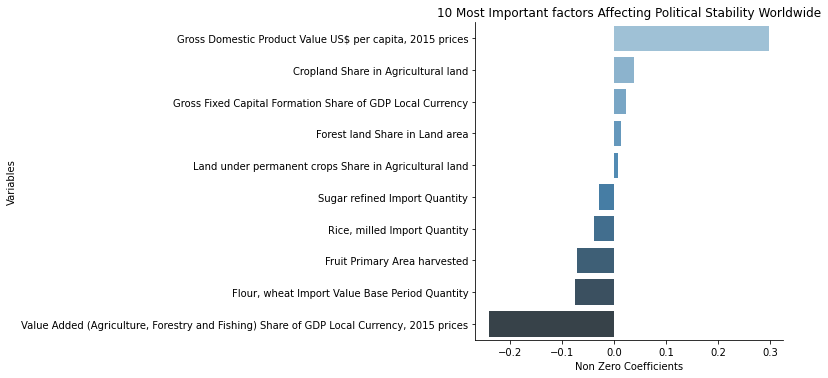

In [8]:
political_lasso = political_L.iloc[:5,[0,2]].append([political_L.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=political_lasso, kind="bar",palette="Blues_d").set(title='10 Most Important factors Affecting Political Stability Worldwide')
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

Alpha = 0.06

In [10]:
undernourish_lasso = lasso_pipeline(undernourish, target_name = 'undernourish', lasso_alpha = 0.06)

Training Shape: (3055, 999)
Testing Shape (578, 999)
score on training dataset 0.4862477035556678
score on testing dataset 0.3252511517889285
R squared score on training 0.4862477035556678
R squared score on testing 0.3252511517889285
Mean Absolute Error on training 0.5069608362860314
Mean Absolute Error on testing 0.5059117088687162


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


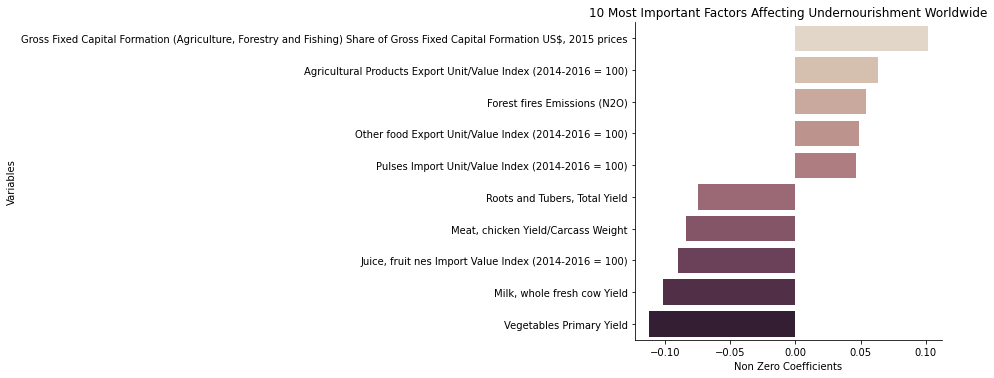

In [11]:
undernourish_World_lasso = undernourish_lasso.iloc[:5,[0,2]].append([undernourish_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_World_lasso, kind="bar",palette="ch:.25").set(title='10 Most Important Factors Affecting Undernourishment Worldwide')
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

Alpha = 0.12

Training Shape: (3055, 999)
Testing Shape (771, 999)
score on training dataset 0.4156977505734426
score on testing dataset 0.3115764356454511
R squared score on training 0.4156977505734426
R squared score on testing 0.3115764356454511
Mean Absolute Error on training 0.5403432015046475
Mean Absolute Error on testing 0.5098859007055162


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


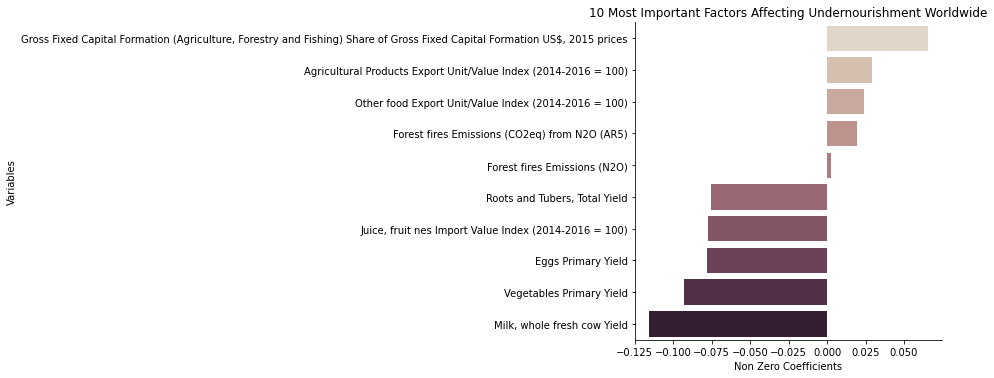

In [ ]:
undernourish_World_lasso = undernourish_lasso.iloc[:5,[0,2]].append([undernourish_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_World_lasso, kind="bar",palette="ch:.25").set(title='10 Most Important Factors Affecting Undernourishment Worldwide')
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

# By Political Continent


## Asia

In [ ]:
political_Asia = pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Political_continent/political_Asia.csv")

In [ ]:
political_Asia.shape

(874, 1003)

In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(political_Asia))

# fill NAs
political_Asia = political_Asia.fillna(0)

0.018762933168458014


Training Shape: (782, 999)
Testing Shape (138, 999)
score on training dataset 0.5954796547266706
score on testing dataset 0.6085946584993815
R squared score on training 0.5954796547266706
R squared score on testing 0.6085946584993815
Mean Absolute Error on training 0.5247211845823034
Mean Absolute Error on testing 0.5230428070350854


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


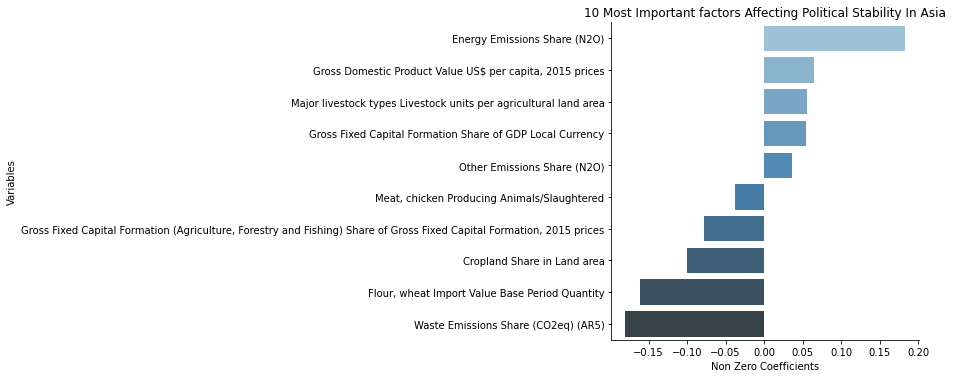

In [ ]:
p_asia_lasso = lasso_pipeline(political_Asia, target_name = 'political')
political_asia_lasso = p_asia_lasso.iloc[:5,[0,2]].append([p_asia_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=political_asia_lasso, kind="bar",palette="Blues_d").set(title='10 Most Important factors Affecting Political Stability In Asia')
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")


## Africa

In [ ]:
political_Africa= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Political_continent/political_Africa.csv")

In [ ]:
political_Africa.shape

(1016, 1003)

In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(political_Africa))

# fill NAs
political_Africa = political_Africa.fillna(0)

0.01907957230670194


Training Shape: (908, 999)
Testing Shape (162, 999)
score on training dataset 0.5158326942687419
score on testing dataset 0.4858478192028174
R squared score on training 0.5158326942687419
R squared score on testing 0.4858478192028174
Mean Absolute Error on training 0.5674172366603345
Mean Absolute Error on testing 0.5066178683817737


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


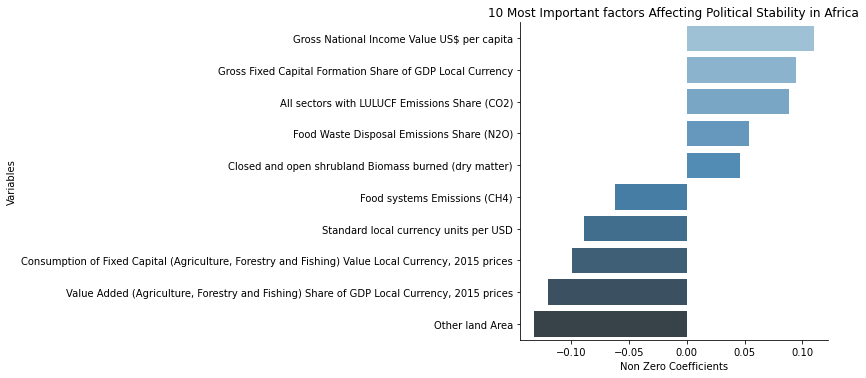

In [ ]:
political_Africa_lasso=lasso_pipeline(political_Africa, target_name = 'political')
political_Africa_lasso = political_Africa_lasso.iloc[:5,[0,2]].append([political_Africa_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=political_Africa_lasso, kind="bar",palette="Blues_d").set(title='10 Most Important factors Affecting Political Stability in Africa')
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

## Europe

In [ ]:
political_Europe= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Political_continent/political_Europe.csv")

In [ ]:
political_Europe.head(3)

,Year,Area Code,Continent,political,67907246,69937225,69705008,67897246,67897245,67897230,...,4725610,66555110,4635312,18675616,89864,89865,898464,898465,18675622,1719465
0,2000,1,Europe,-0.68,162.5807,0.0,32.8890,141.3584,466.4827,0.0001,...,516.0,835.0,4900.0,0.0,6920.0,3952.0,93.0,54.0,0.0,8.0
1,2000,3,Europe,-0.54,4658.3563,0.0,15.4679,3824.9803,12622.4349,0.0027,...,6333.0,445.0,617.0,0.0,482.0,1635.0,57.0,187.0,52.0,120.0
2,2000,6,Europe,1.17,0.0000,0.0,0.2325,0.0000,0.0000,0.0000,...,NaN,22.0,NaN,80.0,NaN,NaN,NaN,NaN,23.0,NaN


In [ ]:
political_Europe.shape

(804, 1003)

In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(political_Europe))

# fill NAs
political_Europe = political_Europe.fillna(0)

0.033582089552238806


Training Shape: (718, 999)
Testing Shape (129, 999)
score on training dataset 0.6912999215572092
score on testing dataset 0.6927947324220374
R squared score on training 0.6912999215572092
R squared score on testing 0.6927947324220374
Mean Absolute Error on training 0.41655314486461364
Mean Absolute Error on testing 0.4138874600747007


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


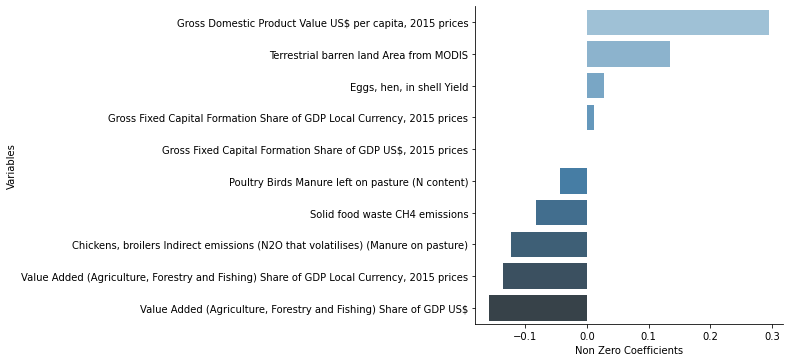

In [ ]:
political_Europe_lasso=lasso_pipeline(political_Europe, target_name = 'political')
political_Europe_lasso = political_Europe_lasso.iloc[:5,[0,2]].append([political_Europe_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=political_Europe_lasso, kind="bar", palette="Blues_d")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

##North America

In [ ]:
political_NorthAmerica= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Political_continent/political_NorthAmerica.csv")

In [ ]:
political_NorthAmerica.head(3)

,Year,Area Code,Continent,political,67907246,69937225,69705008,67897246,67897245,67897230,...,4725610,66555110,4635312,18675616,89864,89865,898464,898465,18675622,1719465
0,2000,8,North America,0.71,0.0000,0.0,0.6975,0.0000,0.0000,0.0000,...,90.0,4.0,40.0,69.0,107.0,80.0,22.0,17.0,6.0,63.0
1,2000,12,North America,1.28,11441.5951,0.0,7.8066,8938.5508,50838.3192,0.0107,...,1932.0,2.0,2000.0,900.0,150.0,601.0,81.0,284.0,254.0,414.0
2,2000,14,North America,1.15,0.0000,0.0,3.5051,0.0000,0.0000,0.0000,...,1060.0,2.0,310.0,1600.0,1859.0,3792.0,50.0,105.0,612.0,103.0


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(political_NorthAmerica))

# fill NAs
political_NorthAmerica = political_NorthAmerica.fillna(0)

0.028166056155259276


Training Shape: (403, 999)
Testing Shape (72, 999)
score on training dataset 0.7273696899428135
score on testing dataset 0.7687525012674276
R squared score on training 0.7273696899428135
R squared score on testing 0.7687525012674276
Mean Absolute Error on training 0.42650202280633304
Mean Absolute Error on testing 0.3928829493208393


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


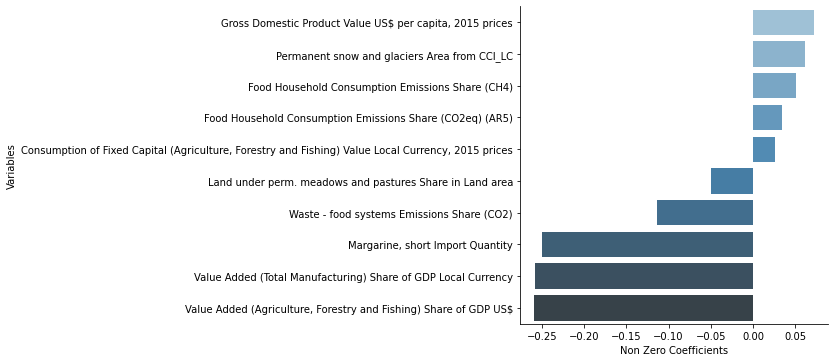

In [ ]:
political_NorthAmerica_lasso=lasso_pipeline(political_NorthAmerica, target_name = 'political')
political_NorthAmerica_lasso = political_NorthAmerica_lasso.iloc[:5,[0,2]].append([political_NorthAmerica_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=political_NorthAmerica_lasso, kind="bar", palette="Blues_d")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

## South America

In [ ]:
political_SouthAmerica= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Political_continent/political_SouthAmerica.csv")

In [ ]:
political_SouthAmerica.head(3)

,Year,Area Code,Continent,political,67907246,69937225,69705008,67897246,67897245,67897230,...,4725610,66555110,4635312,18675616,89864,89865,898464,898465,18675622,1719465
0,2000,9,South America,0.10,4.217921e+05,0.0,356.5994,295232.0537,1631116.188,0.3425,...,11451.0,99870.0,53258.0,4000.0,272.0,944.0,45.0,155.0,800.0,110.0
1,2000,19,South America,-0.24,1.104915e+06,0.0,61.6915,317945.1242,1907280.682,0.4005,...,171.0,33831.0,4888.0,1200.0,3676.0,17791.0,59.0,300.0,33.0,4.0
2,2000,21,South America,0.19,4.404393e+06,0.0,1240.0209,933359.9312,5557032.985,1.1670,...,6407.0,173453.5,193000.0,17240.0,194912.0,412029.0,58.0,135.0,1237.0,34.0


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(political_SouthAmerica))

# fill NAs
political_SouthAmerica = political_SouthAmerica.fillna(0)

0.03315963042047945


Training Shape: (221, 999)
Testing Shape (39, 999)
score on training dataset 0.7515067863270835
score on testing dataset 0.6058596846412243
R squared score on training 0.7515067863270835
R squared score on testing 0.6058596846412243
Mean Absolute Error on training 0.38465874631348485
Mean Absolute Error on testing 0.4278209264126954


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


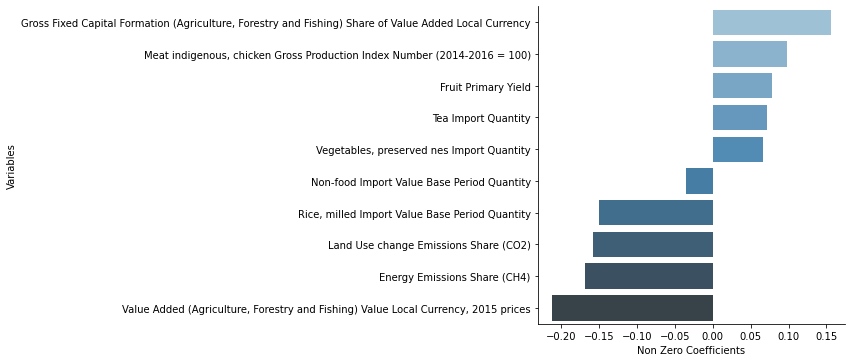

In [ ]:
political_SouthAmerica_lasso= lasso_pipeline(political_SouthAmerica, target_name = 'political')
political_SouthAmerica_lasso = political_SouthAmerica_lasso.iloc[:5,[0,2]].append([political_SouthAmerica_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=political_SouthAmerica_lasso, kind="bar", palette="Blues_d")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

## Oceania 

In [ ]:
political_Oceania= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Political_continent/political_Oceania.csv")

In [ ]:
political_Oceania.head(3)

,Year,Area Code,Continent,political,67907246,69937225,69705008,67897246,67897245,67897230,...,4725610,66555110,4635312,18675616,89864,89865,898464,898465,18675622,1719465
0,2000,10,Oceania,1.33,1.767408e+07,0.0,679.4146,5262833.997,3.092012e+07,6.4932,...,29405.0,431700.0,2545.0,2000.0,33986.0,33524.0,38.0,38.0,520.0,57.0
1,2000,25,Oceania,-0.74,0.000000e+00,0.0,0.7964,0.000,0.000000e+00,0.0000,...,10.0,7.0,350.0,NaN,691.0,1369.0,54.0,106.0,NaN,20.0
2,2000,66,Oceania,0.30,1.364000e+01,0.0,1.7729,5.456,3.273600e+01,0.0000,...,327.0,175.0,877.0,NaN,8180.0,10401.0,34.0,41.0,NaN,84.0


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(political_Oceania))

# fill NAs
political_Oceania = political_Oceania.fillna(0)

0.11825238570004273


Training Shape: (224, 999)
Testing Shape (42, 999)
score on training dataset 0.7392621272935311
score on testing dataset 0.6809267530877647
R squared score on training 0.7392621272935311
R squared score on testing 0.6809267530877647
Mean Absolute Error on training 0.39083227787443925
Mean Absolute Error on testing 0.40246683928712734


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


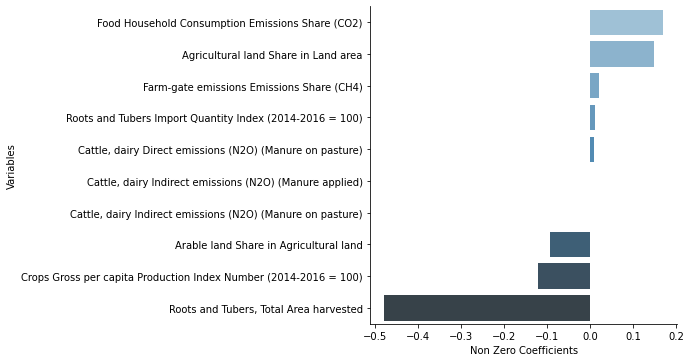

In [ ]:

political_Oceania_lasso= lasso_pipeline(political_Oceania, target_name = 'political')
political_Oceania_lasso = political_Oceania_lasso.iloc[:5,[0,2]].append([political_Oceania_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=political_Oceania_lasso, kind="bar", palette="Blues_d")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

# LASSO on entire Malnourishment

## Lasso alpha = 0.05

In [ ]:
lasso_pipeline(undernourish, target_name = 'undernourish', lasso_alpha = 0.05)

Training Shape: (3055, 999)
Testing Shape (771, 999)
score on training dataset 0.5051478339471589
score on testing dataset 0.3180326170722071
R squared score on training 0.5051478339471589
R squared score on testing 0.3180326170722071
Mean Absolute Error on training 0.49669164952165984
Mean Absolute Error on testing 0.504567816512806


,non_zero_coefficient,code,variable_name
0,0.105371,2203061392,"Gross Fixed Capital Formation (Agriculture, Fo..."
1,0.067417,1882494,Agricultural Products Export Unit/Value Index ...
2,0.066044,69927230,Forest fires Emissions (N2O)
3,0.054038,1954464,Pulses Import Unit/Value Index (2014-2016 = 100)
4,0.052855,1848494,Other food Export Unit/Value Index (2014-2016 ...
5,0.037861,656465,"Coffee, green Import Quantity Index (2014-2016..."
6,0.024772,56462,Maize Import Value Index (2014-2016 = 100)
7,0.019702,111462,"Flour, cereals Import Value Index (2014-2016 =..."
8,0.019346,167464,Sugar nes Import Unit/Value Index (2014-2016 =...
9,0.012827,6992724313,Forest fires Emissions (CO2eq) from N2O (AR5)


In [ ]:
lasso_pipeline(undernourish, target_name = 'undernourish', lasso_alpha = 0.055)

Training Shape: (3055, 999)
Testing Shape (771, 999)
score on training dataset 0.4947308588900897
score on testing dataset 0.3194097455273397
R squared score on training 0.4947308588900897
R squared score on testing 0.3194097455273397
Mean Absolute Error on training 0.5027260742963594
Mean Absolute Error on testing 0.5054523932195484


,non_zero_coefficient,code,variable_name
0,0.103737,2203061392,"Gross Fixed Capital Formation (Agriculture, Fo..."
1,0.065346,1882494,Agricultural Products Export Unit/Value Index ...
2,0.057842,69927230,Forest fires Emissions (N2O)
3,0.050786,1848494,Other food Export Unit/Value Index (2014-2016 ...
4,0.050405,1954464,Pulses Import Unit/Value Index (2014-2016 = 100)
5,0.030857,656465,"Coffee, green Import Quantity Index (2014-2016..."
6,0.021208,56462,Maize Import Value Index (2014-2016 = 100)
7,0.016256,111462,"Flour, cereals Import Value Index (2014-2016 =..."
8,0.014744,6992724313,Forest fires Emissions (CO2eq) from N2O (AR5)
9,0.012103,167464,Sugar nes Import Unit/Value Index (2014-2016 =...


In [ ]:
lasso_pipeline(undernourish, target_name = 'undernourish', lasso_alpha = 0.06)

Training Shape: (3055, 999)
Testing Shape (771, 999)
score on training dataset 0.4862477035556678
score on testing dataset 0.32263069085309903
R squared score on training 0.4862477035556678
R squared score on testing 0.32263069085309903
Mean Absolute Error on training 0.5069608362860314
Mean Absolute Error on testing 0.5049785351099388


,non_zero_coefficient,code,variable_name
0,0.102008,2203061392,"Gross Fixed Capital Formation (Agriculture, Fo..."
1,0.063227,1882494,Agricultural Products Export Unit/Value Index ...
2,0.053969,69927230,Forest fires Emissions (N2O)
3,0.048827,1848494,Other food Export Unit/Value Index (2014-2016 ...
4,0.046390,1954464,Pulses Import Unit/Value Index (2014-2016 = 100)
5,0.027396,656465,"Coffee, green Import Quantity Index (2014-2016..."
6,0.017684,56462,Maize Import Value Index (2014-2016 = 100)
7,0.015421,6992724313,Forest fires Emissions (CO2eq) from N2O (AR5)
8,0.012028,111462,"Flour, cereals Import Value Index (2014-2016 =..."
9,0.007555,674972332,Carbon stock change in forests Net emissions/r...


In [ ]:
lasso_pipeline(undernourish, target_name = 'undernourish', lasso_alpha = 0.12)

Training Shape: (3055, 999)
Testing Shape (771, 999)
score on training dataset 0.4156977505734426
score on testing dataset 0.3115764356454511
R squared score on training 0.4156977505734426
R squared score on testing 0.3115764356454511
Mean Absolute Error on training 0.5403432015046475
Mean Absolute Error on testing 0.5098859007055162


,non_zero_coefficient,code,variable_name
0,0.065782,2203061392,"Gross Fixed Capital Formation (Agriculture, Fo..."
1,0.029209,1882494,Agricultural Products Export Unit/Value Index ...
2,0.023763,1848494,Other food Export Unit/Value Index (2014-2016 ...
3,0.019305,6992724313,Forest fires Emissions (CO2eq) from N2O (AR5)
4,0.002674,69927230,Forest fires Emissions (N2O)
5,-0.000242,220306161,"Gross Fixed Capital Formation (Agriculture, Fo..."
6,-0.008513,10585424,"Meat, chicken Yield/Carcass Weight"
7,-0.010652,10625410,"Eggs, hen, in shell Yield"
8,-0.012662,17175419,"Cereals, Total Yield"
9,-0.023341,1889465,Fruit and Vegetables Import Quantity Index (20...


# LASSO With Malnourishment Data by Continent

## Africa

In [ ]:
undernourish_Africa= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Undernourish_continent/undernourish_selected_Africa.csv")

In [ ]:
undernourish_Africa.head(3)

,Year,Area Code,Continent,undernourish,18955610,18955622,17655510,19415610,19415622,19445610,...,6516723113,5063724313,5063723113,5062723113,5059724413,6824724413,5062724313,69967274,65007273,69745007
0,2002,4,Africa,8.0,16259.0,8490.0,549279.0,21083.0,12763.0,8610899.0,...,0.0000,2665.4277,2665.4277,113.4703,217.9621,5218.6901,113.4703,0.0,11602.7719,585.2712
1,2002,7,Africa,67.5,303632.0,201066.0,160698.0,191346.0,60324.0,603222.0,...,44189.8035,1863.2939,1863.2939,112.7669,155.2233,22595.4050,112.7669,0.0,458.2622,79711.3947
2,2002,20,Africa,23.7,29200.0,20274.0,57275.0,39692.0,14676.0,194537.0,...,40513.8067,1043.6978,1043.6978,21.8170,77.6140,6638.1276,21.8170,0.0,728.7343,133.1957


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(undernourish_Africa))

# fill NAs
undernourish_Africa = undernourish_Africa.fillna(0)

0.04237864071457002


Training Shape: (656, 999)
Testing Shape (164, 999)
score on training dataset 0.5298296756707709
score on testing dataset 0.48614646144265006
R squared score on training 0.5298296756707709
R squared score on testing 0.48614646144265006
Mean Absolute Error on training 0.5680773531820072
Mean Absolute Error on testing 0.5599539446874443


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


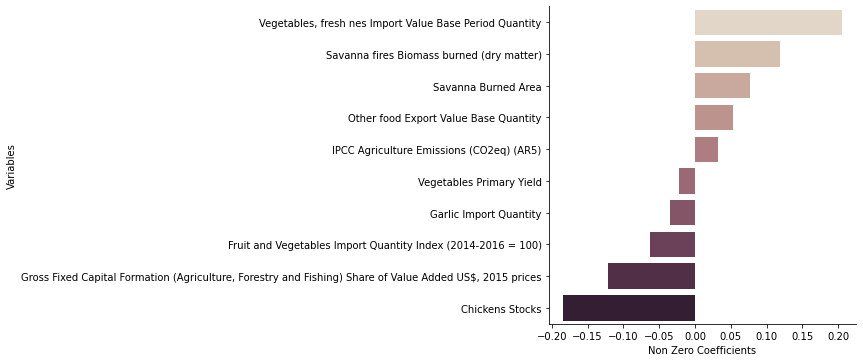

In [ ]:
undernourish_Africa_lasso = lasso_pipeline(undernourish_Africa, target_name = 'undernourish',  lasso_alpha = 0.15)

undernourish_Africa_lasso = undernourish_Africa_lasso.iloc[:5,[0,2]].append([undernourish_Africa_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_Africa_lasso, kind="bar",palette="ch:.25")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")

## Asia

In [ ]:
undernourish_Asia= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Undernourish_continent/undernourish_selected_Asia.csv")

In [ ]:
undernourish_Asia.head(3)

,Year,Area Code,Continent,undernourish,18955610,18955622,17655510,19415610,19415622,19445610,...,6516723113,5063724313,5063723113,5062723113,5059724413,6824724413,5062724313,69967274,65007273,69745007
0,2002,2,Asia,47.8,4536.0,5532.0,304321.0,8972.0,6909.0,1377836.0,...,0.0000,2151.3990,2151.3990,313.8126,514.5073,9175.5191,313.8126,0.0,134.4448,562.0837
1,2002,16,Asia,15.9,6621.0,6932.0,479698.0,9227.0,17350.0,2824204.0,...,513.7834,5996.4232,5996.4232,1088.9753,2029.1487,59629.5511,1088.9753,0.0,8438.4960,3862.9331
2,2002,26,Asia,2.6,10122.0,7944.0,20845.0,21670.0,24120.0,42252.0,...,1023.9643,19.7279,19.7279,13.3073,6.4801,20.4328,13.3073,0.0,459.8899,541.1974


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(undernourish_Asia))

# fill NAs
undernourish_Asia = undernourish_Asia.fillna(0)

0.04127879519336727


Training Shape: (640, 999)
Testing Shape (160, 999)
score on training dataset 0.6030612089885667
score on testing dataset 0.30677512443323995
R squared score on training 0.6030612089885667
R squared score on testing 0.30677512443323995
Mean Absolute Error on training 0.4519637251926511
Mean Absolute Error on testing 0.5315015312930336


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


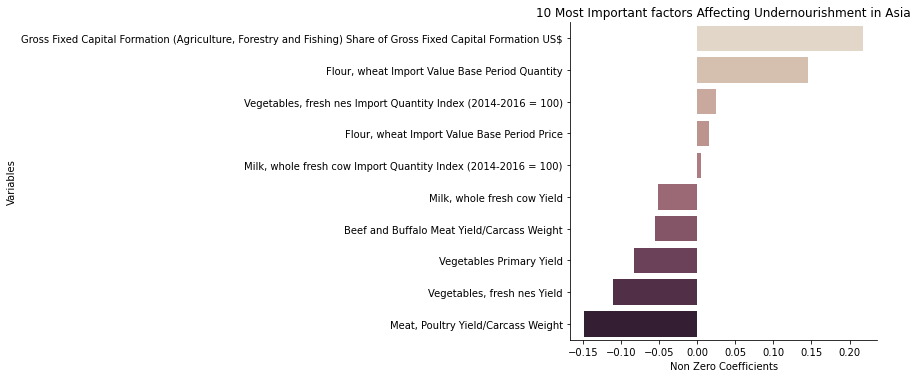

In [ ]:
undernourish_Asia_lasso = lasso_pipeline(undernourish_Asia, target_name = 'undernourish',  lasso_alpha = 0.15)

undernourish_Asia_lasso = undernourish_Asia_lasso.iloc[:5,[0,2]].append([undernourish_Asia_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_Asia_lasso, kind="bar",palette="ch:.25").set(title='10 Most Important factors Affecting Undernourishment in Asia')
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")


## Europe

In [ ]:
undernourish_Europe= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Undernourish_continent/undernourish_selected_Europe.csv")

In [ ]:
undernourish_Europe.head(3)

,Year,Area Code,Continent,undernourish,18955610,18955622,17655510,19415610,19415622,19445610,...,6516723113,5063724313,5063723113,5062723113,5059724413,6824724413,5062724313,69967274,65007273,69745007
0,2002,1,Europe,26.1,2002.0,2503.0,50256.0,8687.0,4467.0,420090.0,...,207.1960,338.79420,338.79420,18.69640,28.11490,686.5898,18.69640,0.0,426.2235,275.5144
1,2002,3,Europe,4.9,62216.0,23493.0,71800.0,42852.0,25578.0,470073.0,...,0.0000,394.70050,394.70050,235.25130,253.88195,2856.9771,235.25130,0.0,582.9990,1392.1130
2,2002,11,Europe,2.5,367605.0,308987.0,850636.0,238887.0,371031.0,767312.0,...,156.2675,251.87735,251.87735,591.48655,876.07210,5919.0927,591.48655,0.0,6803.4709,5424.8755


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(undernourish_Europe))

# fill NAs
undernourish_Europe = undernourish_Europe.fillna(0)

0.021391089888230047


Training Shape: (640, 999)
Testing Shape (160, 999)
score on training dataset 0.3671059101305504
score on testing dataset 0.1517386347331834
R squared score on training 0.3671059101305504
R squared score on testing 0.1517386347331834
Mean Absolute Error on training 0.38278003279041756
Mean Absolute Error on testing 0.2624255885525705


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


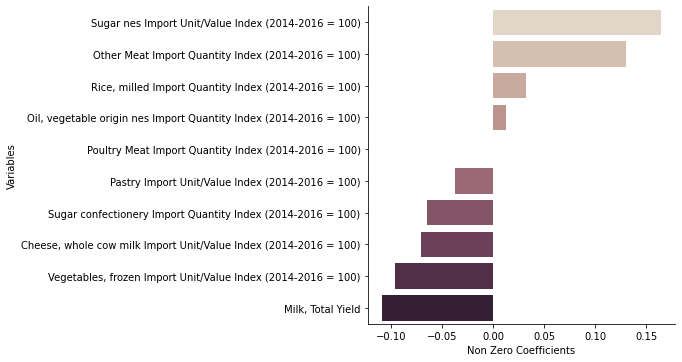

In [ ]:
undernourish_Europe_lasso = lasso_pipeline(undernourish_Europe, target_name = 'undernourish',  lasso_alpha = 0.15)

undernourish_Europe_lasso = undernourish_Europe_lasso.iloc[:5,[0,2]].append([undernourish_Europe_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_Europe_lasso, kind="bar",palette="ch:.25")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")


## North America

In [ ]:
undernourish_NorthAmerica= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Undernourish_continent/undernourish_selected_NorthAmerica.csv")

In [ ]:
undernourish_NorthAmerica.head(3)

,Year,Area Code,Continent,undernourish,18955610,18955622,17655510,19415610,19415622,19445610,...,6516723113,5063724313,5063723113,5062723113,5059724413,6824724413,5062724313,69967274,65007273,69745007
0,2002,14,North America,6.4,19081.0,29319.0,13447.0,9631.0,17851.0,56765.0,...,0.0000,14.0899,14.0899,6.2254,3.1991,39.0749,6.2254,0.0,156.6296,1.1806
1,2002,23,North America,5.8,6515.0,15734.0,17003.0,5075.0,5904.0,27189.0,...,3129.8037,27.8189,27.8189,5.4152,3.6354,144.2224,5.4152,0.0,133.5904,1973.4430
2,2002,33,North America,2.5,864584.0,1299109.0,4301177.0,768119.0,973732.0,4564376.0,...,110514.6189,2529.1422,2529.1422,1872.4914,5245.8368,31139.0031,1872.4914,0.0,42832.4560,486167.3951


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(undernourish_NorthAmerica))

# fill NAs
undernourish_NorthAmerica = undernourish_NorthAmerica.fillna(0)

0.016430241439424415


Training Shape: (288, 999)
Testing Shape (72, 999)
score on training dataset 0.7551272594275996
score on testing dataset 0.8825406633643503
R squared score on training 0.7551272594275996
R squared score on testing 0.8825406633643503
Mean Absolute Error on training 0.39366030294091625
Mean Absolute Error on testing 0.2511429054554244


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


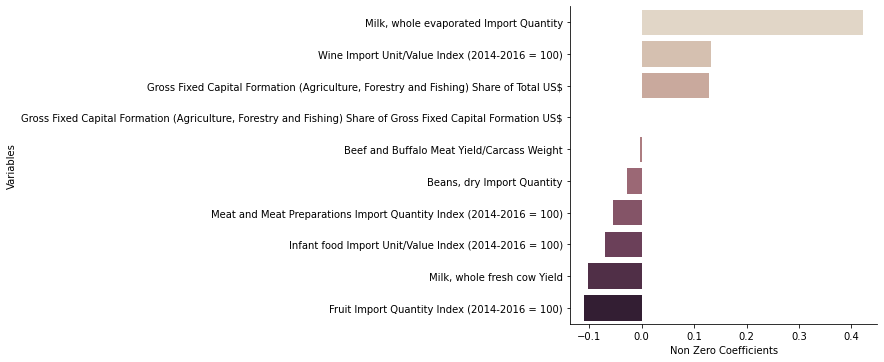

In [ ]:
undernourish_NorthAmerica_lasso = lasso_pipeline(undernourish_NorthAmerica, target_name = 'undernourish',  lasso_alpha = 0.15)

undernourish_NorthAmerica_lasso = undernourish_NorthAmerica_lasso.iloc[:5,[0,2]].append([undernourish_NorthAmerica_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_NorthAmerica_lasso, kind="bar",palette="ch:.25")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")


## South America

In [ ]:
undernourish_SouthAmerica= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Undernourish_continent/undernourish_selected_SouthAmerica.csv")

In [ ]:
undernourish_SouthAmerica.head(3)

,Year,Area Code,Continent,undernourish,18955610,18955622,17655510,19415610,19415622,19445610,...,6516723113,5063724313,5063723113,5062723113,5059724413,6824724413,5062724313,69967274,65007273,69745007
0,2002,9,South America,3.0,7247.0,11203.0,3562104.0,6216.0,10290.0,14626.0,...,1.278826e+05,22827.5421,22827.5421,854.0582,1776.1755,91933.2835,854.0582,0.0,23186.9175,62453.6316
1,2002,19,South America,27.9,4090.0,6855.0,431781.0,48801.0,21441.0,474110.0,...,6.195015e+04,3919.0715,3919.0715,320.2162,389.3407,19085.6390,320.2162,0.0,1878.0787,73950.9090
2,2002,21,South America,10.7,61675.0,124185.0,17298391.0,773439.0,217445.0,7812012.0,...,1.615951e+06,77156.3181,77156.3181,8300.2046,10535.2411,336681.5935,8300.2046,0.0,54055.3258,628134.6091


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(undernourish_SouthAmerica))

# fill NAs
undernourish_SouthAmerica = undernourish_SouthAmerica.fillna(0)

0.019183677039058263


Training Shape: (192, 999)
Testing Shape (48, 999)
score on training dataset 0.7399840835457807
score on testing dataset 0.3454711864466664
R squared score on training 0.7399840835457807
R squared score on testing 0.3454711864466664
Mean Absolute Error on training 0.3862182214901111
Mean Absolute Error on testing 0.3598614002631144


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


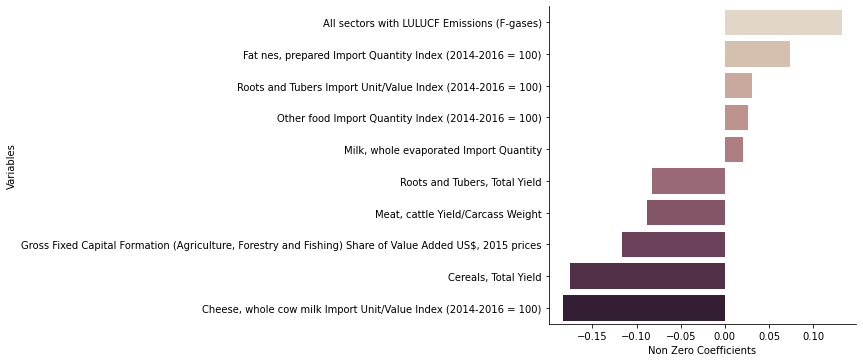

In [ ]:
undernourish_SouthAmerica_lasso = lasso_pipeline(undernourish_SouthAmerica, target_name = 'undernourish',  lasso_alpha = 0.15)

undernourish_SouthAmerica_lasso = undernourish_SouthAmerica_lasso.iloc[:5,[0,2]].append([undernourish_SouthAmerica_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_SouthAmerica_lasso, kind="bar",palette="ch:.25")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")


## Oceania

In [ ]:
undernourish_Oceania= pd.read_csv("drive/Shareddrives/ML_&_Econometrics/Merged/Undernourish_continent/undernourish_selected_Oceania.csv")

In [ ]:
undernourish_Oceania.head(3)

,Year,Area Code,Continent,undernourish,18955610,18955622,17655510,19415610,19415622,19445610,...,6516723113,5063724313,5063723113,5062723113,5059724413,6824724413,5062724313,69967274,65007273,69745007
0,2002,10,Oceania,2.5,136683.0,396194.0,3895830.0,109638.0,186214.0,65276.0,...,68434.0520,15919.1693,15919.1693,614.30115,6119.6872,135541.9906,614.30115,0.0,44943.6355,81061.3101
1,2002,25,Oceania,13.3,1682.0,840.0,3140.0,2428.0,2212.0,21493.0,...,189.0351,7.3727,7.3727,2.82990,23.4029,51.8006,2.82990,0.0,28.7125,929.7940
2,2002,66,Oceania,4.0,3558.0,5970.0,17963.0,6247.0,5369.0,138130.0,...,0.0000,209.6941,209.6941,21.72980,100.4573,748.2636,21.72980,0.0,130.4659,985.7341


In [ ]:
# do not drop top NAs because the dataset already small 
print(total_percentage_missing(undernourish_Oceania))

# fill NAs
undernourish_Oceania = undernourish_Oceania.fillna(0)

0.049308215703765895


Training Shape: (144, 999)
Testing Shape (36, 999)
score on training dataset 0.8613605574530708
score on testing dataset 0.9278377756747672
R squared score on training 0.8613605574530708
R squared score on testing 0.9278377756747672
Mean Absolute Error on training 0.28622432453355107
Mean Absolute Error on testing 0.23595253628509288


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(*args, **kwargs)


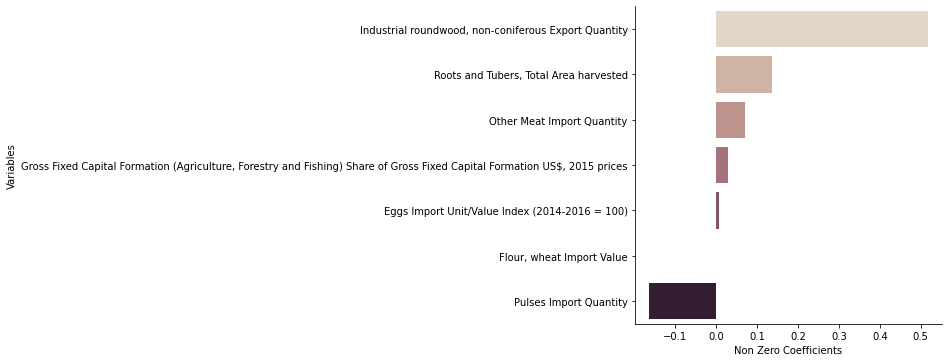

In [ ]:
undernourish_Oceania_lasso = lasso_pipeline(undernourish_Oceania, target_name = 'undernourish',  lasso_alpha = 0.15)

undernourish_Oceania_lasso = undernourish_Oceania_lasso.iloc[:5,[0,2]].append([undernourish_Oceania_lasso.iloc[-5:,[0,2]]])
p = sns.catplot(x = "non_zero_coefficient", y="variable_name", data=undernourish_Oceania_lasso, kind="bar",palette="ch:.25")
p.set(xlabel = "Non Zero Coefficients", ylabel = "Variables")